In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# os
import os 
import random
import pickle
import zipfile
import math

# pandas, geopandas
import pandas as pd

# path
import pathlib
from glob import glob
from pathlib import Path

# requests
import requests
from PIL import Image
from io import BytesIO

# numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import recall_score, accuracy_score, make_scorer, confusion_matrix, plot_confusion_matrix

# models (ensemble)
!pip install lightgbm
import lightgbm as lgb

# warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
CFG = {
    'SEED': 41
}

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

def open_img(url, title=None, headers={"User-Agent" : "Mozilla/5.0"}):

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  plt.figure(figsize=(6, 6))
  plt.title(title, fontsize=20)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  plt.show()

with open(str(path / 'weather' / 'ASOS'), 'rb') as f:
  asos = pickle.load(f)

pd.set_option('display.float_format', '{:,.5f}'.format)

In [4]:
def bug_step(data):

  data_dict = {'STATION_ID': data.STATION_ID, 'LATITUDE': data.LATITUDE, 'LONGITUDE': data.LONGITUDE,
                'STORUNST': data.STORUNST, 'FROR_CD': data.FROR_CD, 'FRTP_CD': data.FRTP_CD,
                'KOFTR_GROU': data.KOFTR_GROU, 'MEAN': data.MEAN, 'STDDEV': data.STDDEV,
                'MIN': data.MIN, 'MAX': data.MAX, 'SEED': data.SEED * -1}

  df_bug = pd.DataFrame(data=data_dict)
  station = list(set(df_bug.STATION_ID))
  station.sort()
  station_dict = {}

  for id in station:
    station_dict[str(id)] = asos[asos.STATION_ID == id].to_numpy()

  cnt = 0
  data_list = []
  for row in df_bug.itertuples():
    cnt += 1
    if cnt % 100000 == 0:
      print(cnt)
    data_list.append(station_dict[str(row[1])])
  data_list = np.array(data_list).reshape(-1, len(asos.columns))
  tmp_df = pd.DataFrame(data=data_list, columns=asos.columns)
  df_bug = pd.concat([df_bug, tmp_df], axis=1)
  df_bug = df_bug.drop(['STATION_ID'], axis=1)

  df_bug['LABEL'] = 0
  return df_bug

def safe_step(data):

  data_dict = {'STATION_ID': data.STATION_ID, 'LATITUDE': data.LATITUDE, 'LONGITUDE': data.LONGITUDE,
                'STORUNST': data.STORUNST, 'FROR_CD': data.FROR_CD, 'FRTP_CD': data.FRTP_CD,
                'KOFTR_GROU': data.KOFTR_GROU, 'MEAN': data.MEAN, 'STDDEV': data.STDDEV,
                'MIN': data.MIN, 'MAX': data.MAX, 'SEED': data.SEED}

  df_safe = pd.DataFrame(data=data_dict)
  station = list(set(df_safe.STATION_ID))
  station.sort()
  station_dict = {}

  for id in station:
    station_dict[str(id)] = asos[asos.STATION_ID == id].to_numpy()
  
  cnt = 0
  data_list = []
  for row in df_safe.itertuples():
    cnt += 1
    if cnt % 100000 == 0:
      print(cnt)
    data_list.append(station_dict[str(row[1])])
  data_list = np.array(data_list).reshape(-1, len(asos.columns))
  tmp_df = pd.DataFrame(data=data_list, columns=asos.columns)
  df_safe = pd.concat([df_safe, tmp_df], axis=1)
  df_safe = df_safe.drop(['STATION_ID'], axis=1)
  
  df_safe = df_safe.reset_index(drop=True)
  df_safe['LABEL'] = 1

  return df_safe


def encode_ml(df_bug, df_safe):

  # 비감염(정상) = 1 감염(비정상) = 0
  if df_bug.isnull().sum().sum() + df_safe.isnull().sum().sum() == 0:
    df_total = pd.concat([df_bug, df_safe], axis=0)
  else:
    print('NULL 존재')
    
  lat_true = False
  log_true = False
    
  col_list = ['DROP']* len(df_total.columns)
  for idx, c in enumerate(df_total.columns):
    if c in ['LATITUDE', 'LONGITUDE', 'STATION_NAME', 'STATION_ID', 'AWS_STATION_ID']:
      if c ==  'LATITUDE':
        if lat_true == False:
          col_list[idx] = c
          lat_true = True 

      if c == 'LONGITUDE':
        if log_true == False:
          col_list[idx] = c
          log_true = True
    else:
      col_list[idx] = c

  print(col_list)

  df_total.columns = col_list
  df_total = df_total.drop(['DROP'], axis=1)

  lat_true = False
  log_true = False

  col_list = ['DROP']* len(df_safe.columns)
  for idx, c in enumerate(df_safe.columns):
    if c in ['LATITUDE', 'LONGITUDE', 'STATION_NAME', 'STATION_ID', 'AWS_STATION_ID']:
      if c ==  'LATITUDE':
        if lat_true == False:
          col_list[idx] = c
          lat_true = True 
      
      if c == 'LONGITUDE':
        if log_true == False:
          col_list[idx] = c
          log_true = True

    else:
      col_list[idx] = c

  df_safe.columns = col_list
  df_safe = df_safe.drop(['DROP'], axis=1)

  # X_train, X_test
  y = df_total.pop('LABEL')

  return df_total, df_safe, y

def split_data(df_total, y):

  X_train, X_test, y_train, y_test = train_test_split(df_total, y, random_state=CFG['SEED'], shuffle=True, stratify=y)

  # X_train, X_val
  X_train_len = int(len(X_train)*0.80)

  X_val = X_train[X_train_len:]
  y_val = y_train[X_train_len:]

  X_train = X_train[:X_train_len]
  y_train = y_train[:X_train_len]

  return X_train, y_train, X_test, y_test, X_val, y_val

def preprocess_type(dataframe):
  """
  Functions to change the type of a data frame column
  """
  for col in dataframe.columns:
    if not col in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU']:
      
      if not col in ['LATITUDE', 'LONGITUDE', 'MEAN', 'STDDEV', 'MIN', 'MAX']:
        dataframe[col] = dataframe[col].astype('float32')
      else:
        dataframe[col] = dataframe[col].astype('float64')
    
    else:
      dataframe[col] = dataframe[col].astype('object')

  return dataframe

def preprocess_train_nominal(dataframe):
  """
  Function for preprocessing nominal variables based on clinical map attribute information
  """

  STORUNST =[1, 2, 0] # 입목존재코드
  FROR_CD = [1, 2, 0] # 임종코드
  FRTP_CD = [1, 2, 3, 4, 0] # 임상코드
  KOFTR_GROU = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 10,
                31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
                43, 44, 45, 46, 47, 48, 49, 30, 61, 62, 63, 64,
                65, 66, 67, 68, 60, 77, 78, 81, 82, 83, 91, 92, 
                93, 94, 95, 99] # 수종그룹코드

  # 처음에 기억할 데이터프레임 개수
  fst_df_len = len(dataframe)
  
  # 정의된 원핫인코딩 컬럼을 만들기 위해 일부러 데이터를 추가하여 원핫인코딩 한 후 제거
  plus_data = [[0]*4 for _ in range(52)]
 
  for idx, (s, f) in enumerate(zip(STORUNST, FROR_CD)):
    plus_data[idx][0], plus_data[idx][1] = s, f
  for idx, f in enumerate(FRTP_CD): 
    plus_data[idx][2] = f
  for idx, k in enumerate(KOFTR_GROU): 
    plus_data[idx][3] = k
  
  # 처리할 컬럼
  cols = ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU']

  # 새로운 데이터프레임 생성
  plus_dataframe = pd.DataFrame(data=plus_data, columns=cols)

  # 데이터프레임 병합
  dataframe_oh = pd.concat([dataframe[cols], plus_dataframe], axis=0)
  dataframe_oh = dataframe_oh.reset_index(drop=True)
  
  # 데이터프레임 원핫 인코딩
  oh_encoder = OneHotEncoder()
  oh_encoder.fit(dataframe_oh)
  dataframe_oh = oh_encoder.transform(dataframe_oh).toarray()

  dataframe = dataframe.drop(cols, axis=1)
  dataframe = np.array(dataframe)

  dataframe = np.concatenate([dataframe, dataframe_oh[:fst_df_len]], axis=1)
  
  return dataframe, oh_encoder

def preprocess_test_nominal(dataframe, oh_encoder):
  """
  Function for preprocessing nominal variables based on clinical map attribute information
  """

  STORUNST =[1, 2, 0] # 입목존재코드
  FROR_CD = [1, 2, 0] # 임종코드
  FRTP_CD = [1, 2, 3, 4, 0] # 임상코드
  KOFTR_GROU = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 10,
                31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
                43, 44, 45, 46, 47, 48, 49, 30, 61, 62, 63, 64,
                65, 66, 67, 68, 60, 77, 78, 81, 82, 83, 91, 92, 
                93, 94, 95, 99] # 수종그룹코드

  # 처음에 기억할 데이터프레임 개수
  fst_df_len = len(dataframe)
  
  # 정의된 원핫인코딩 컬럼을 만들기 위해 일부러 데이터를 추가하여 원핫인코딩 한 후 제거
  plus_data = [[0]*4 for _ in range(52)]

  for idx, (s, f) in enumerate(zip(STORUNST, FROR_CD)):
    plus_data[idx][0], plus_data[idx][1] = s, f
  for idx, f in enumerate(FRTP_CD): 
    plus_data[idx][2] = f
  for idx, k in enumerate(KOFTR_GROU): 
    plus_data[idx][3] = k
  
  # 처리할 컬럼
  cols = ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU']

  # 새로운 데이터프레임 생성
  plus_dataframe = pd.DataFrame(data=plus_data, columns=cols)

  # 데이터프레임 병합
  dataframe_oh = pd.concat([dataframe[cols], plus_dataframe], axis=0)
  dataframe_oh = dataframe_oh.reset_index(drop=True)
  
  # 데이터프레임 원핫 인코딩
  dataframe_oh = oh_encoder.transform(dataframe_oh).toarray()

  dataframe = dataframe.drop(cols, axis=1)
  dataframe = np.array(dataframe)

  dataframe = np.concatenate([dataframe, dataframe_oh[:fst_df_len]], axis=1)
  
  return dataframe


# 울산

In [ ]:
name_string = 'ulsan'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')

lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (744804, 273)	X_test.shape: (310335, 273)	X_val.shape: (186201, 273)      
y_train.shape: (744804,)	y_test.shape: (310335,)		y_val.shape: (186201,)
0.1 7


Text(0.5, 1.0, 'Confusion Matrix')

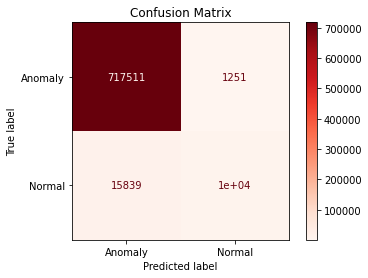

In [ ]:
lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=0.1, n_estimators=100, subsample=0.75, 
                            colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                            max_depth=7)


lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

최적의 accuracy 성능: 0.9767090402307185
최적의 recall 성능: 0.9981567866647523


Text(0.5, 1.0, 'Confusion Matrix')

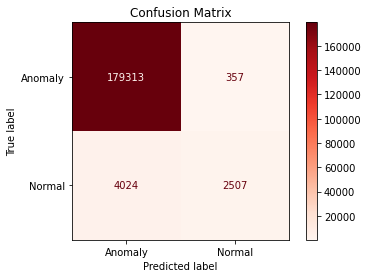

In [ ]:
y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

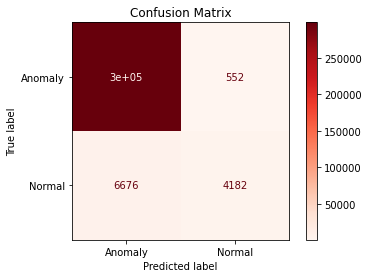

In [ ]:
label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

In [ ]:
y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

현재 index: 0
idx: 4	score: 1.9744902519799374
idx: 6	score: 1.9744958177393852
idx: 9	score: 1.974506754039271
idx: 12	score: 1.9745176903391561
idx: 155	score: 1.9745461047934265
idx: 368	score: 1.9745484474215513
idx: 381	score: 1.9745486426405618
idx: 412	score: 1.9745595789404473
idx: 421	score: 1.9745653399189056
idx: 453	score: 1.9745709056783534
idx: 473	score: 1.9745820371972491
idx: 793	score: 1.9745903360228425
idx: 813	score: 1.9746012723227278
idx: 814	score: 1.974612208622613
idx: 845	score: 1.9746179696010713
idx: 854	score: 1.9746235353605193
idx: 946	score: 1.9746795833930189
idx: 949	score: 1.974690519692904
idx: 978	score: 1.9746911053499354
idx: 981	score: 1.9746966711093832
현재 index: 1000
idx: 1050	score: 1.9747024320878415
idx: 1113	score: 1.9747083882853103
idx: 1131	score: 1.974713954044758
idx: 1153	score: 1.9747304561040913
idx: 1270	score: 1.9747316274181537
idx: 1299	score: 1.974731822637164
idx: 1302	score: 1.9747427589370494
idx: 1352	score: 1.97474295415606

Text(0.5, 1.0, 'Confusion Matrix')

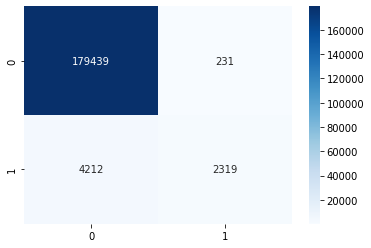

In [ ]:
y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

새로운 모델 및 임계점에 따른 혼동행렬 결과


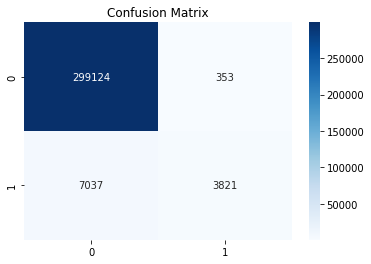

In [ ]:
y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')

(0.95, 1.0)

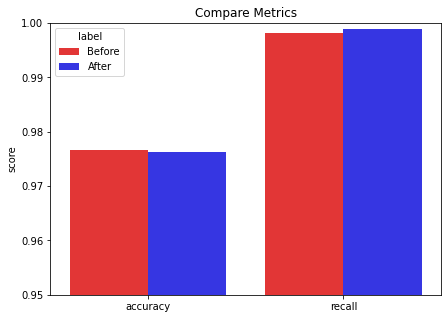

In [ ]:
# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)

In [ ]:
lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=0.1, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=7, skip_drop = threshold)

lgb_model.fit(X_train, y_train)



with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)

df_safe['PROB'] = X_pred_prob[:, 0]

In [ ]:
with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


# 경기

In [ ]:
name_string = 'gyeonggi'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


100000
200000
300000
400000
100000
200000
300000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_

In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')

lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (470240, 273)	X_test.shape: (195934, 273)	X_val.shape: (117561, 273)      
y_train.shape: (470240,)	y_test.shape: (195934,)		y_val.shape: (117561,)
{'fit_time': array([12.36500144, 12.08995557, 12.54637742, 14.4091084 , 11.57414103]), 'score_time': array([0.16669178, 0.17006707, 0.16183257, 0.15725827, 0.16857123]), 'test_recall_score': array([0.90149073, 0.90107347, 0.89921481, 0.90156659, 0.89642681]), 'test_accuracy_score': array([0.85628615, 0.85732817, 0.85734944, 0.85478692, 0.85605223])}
{'fit_time': array([13.11199641, 13.28819394, 13.1132884 , 13.00419641, 15.31250715]), 'score_time': array([0.16848612, 0.16676927, 0.17506385, 0.16234994, 0.161587  ]), 'test_recall_score': array([0.90587187, 0.90352008, 0.90291317, 0.90562531, 0.9050184 ]), 'test_accuracy_score': array([0.86416511, 0.86436713, 0.86375043, 0.86291043, 0.86588763])}
{'fit_time': array([14.09406304, 14.11331487, 13.8581636 , 13.94178391, 16.77860188]), 'score_time': array([0.1666863 , 0.16960049, 0

LGBMClassifier(colsample_bytree=0.8, max_depth=9, objective='binary',
               random_state=41, subsample=0.75, tree_method='gpu_hist')

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')


# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)


iidex = 0
llr = 0
mmd = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    if iidex == np.argmax(s_):
      llr = lr
      mmd = md
      print(llr)
      print(mmd)
      break
    iidex += 1

lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=llr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=mmd, skip_drop = threshold)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)


X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)



df_safe['PROB'] = X_pred_prob[:, 0]



with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


0.1
9


# 경남

In [ ]:
name_string = 'gyeongnam'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
100000
200000
300000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_

In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')


lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (1507004, 273)	X_test.shape: (627919, 273)	X_val.shape: (376751, 273)      
y_train.shape: (1507004,)	y_test.shape: (627919,)		y_val.shape: (376751,)
{'fit_time': array([23.92628241, 24.37697363, 24.12622857, 24.09858203, 24.06102562]), 'score_time': array([0.42839575, 0.48581505, 0.42832398, 0.42728424, 0.44347191]), 'test_recall_score': array([0.99648743, 0.9969207 , 0.99660735, 0.99657639, 0.99666536]), 'test_accuracy_score': array([0.89977472, 0.89748209, 0.89934672, 0.89938653, 0.89963172])}
{'fit_time': array([29.64200974, 27.76435709, 27.50873327, 27.51757932, 29.01263547]), 'score_time': array([0.4532764 , 0.47007966, 0.4482007 , 0.46270752, 0.45051408]), 'test_recall_score': array([0.99672727, 0.99719149, 0.99684333, 0.99659573, 0.99694003]), 'test_accuracy_score': array([0.90486428, 0.90134406, 0.90417749, 0.90451591, 0.90428666])}
{'fit_time': array([29.65323734, 29.61375022, 32.02613831, 30.21651411, 30.24342752]), 'score_time': array([0.47519851, 0.50103927,

LGBMClassifier(colsample_bytree=0.8, max_depth=9, objective='binary',
               random_state=41, subsample=0.75, tree_method='gpu_hist')

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')


# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)


iidex = 0
llr = 0
mmd = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    if iidex == np.argmax(s_):
      llr = lr
      mmd = md
      print(llr)
      print(mmd)
      break
    iidex += 1

lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=llr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=mmd, skip_drop = threshold)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)


X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)



df_safe['PROB'] = X_pred_prob[:, 0]



with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


# 강원

In [ ]:
name_string = 'jeonbuk'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob


# name_string = 'gangwon'

# name_safe = name_string + '_safe_db'
# name_bug = name_string + '_bug_db'

# name_safe_mode = name_string + '_model.pickle'

# name_prob = name_string + '_safe_db_prob'

# with open(str(path / 'dbdata' / name_safe), 'rb') as f:
#   data_safe = pickle.load(f)

# with open(str(path / 'dbdata' / name_bug), 'rb') as f:
#   data_bug = pickle.load(f)


# df_bug = bug_step(data_bug)
# df_safe = safe_step(data_safe)

# df_total, df_safe, y = encode_ml(df_bug, df_safe)

# X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

# seeds = []

# s1 = X_train.pop('SEED')
# s2 = X_test.pop('SEED')
# s3 = X_val.pop('SEED')

# seeds.extend(s1)
# seeds.extend(s2)
# seeds.extend(s3)


# X_train = preprocess_type(X_train)
# X_test = preprocess_type(X_test)
# X_val = preprocess_type(X_val)

# df_safe.pop('LABEL')
# safe_seed = df_safe.pop('SEED')

# X_pred_prob = df_safe.reset_index(drop=True)

# X_pred_prob = preprocess_type(X_pred_prob)

# X_train, oh_encoder = preprocess_train_nominal(X_train)
# X_test = preprocess_test_nominal(X_test, oh_encoder)
# X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
# X_val = preprocess_test_nominal(X_val, oh_encoder)


100000
100000
200000
300000
400000
500000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03'

In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:

    print(lr, md)
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

    a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

    s_ = [i[0] + i[1] for i in a_r]

    lgb_model = lgb_models[np.argmax(s_)]

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')


lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (421289, 273)	X_test.shape: (175538, 273)	X_val.shape: (105323, 273)      
y_train.shape: (421289,)	y_test.shape: (175538,)		y_val.shape: (105323,)
0.01 4
{'fit_time': array([ 9.95378137, 10.0226562 ,  9.94156885,  9.94965696,  9.88126969]), 'score_time': array([0.13768387, 0.12602735, 0.1257782 , 0.12923622, 0.12776256]), 'test_recall_score': array([0.59417307, 0.57184704, 0.5900095 , 0.58446802, 0.592748  ]), 'test_accuracy_score': array([0.92982269, 0.92810178, 0.92982269, 0.92943103, 0.93086628])}
0.01 5
{'fit_time': array([11.06449723, 11.02519202, 11.05064559, 11.0094862 , 11.00111032]), 'score_time': array([0.13750052, 0.13509321, 0.13696313, 0.13129282, 0.13376284]), 'test_recall_score': array([0.58522682, 0.57200538, 0.57473084, 0.56538949, 0.58332674]), 'test_accuracy_score': array([0.9294429 , 0.92845783, 0.92889696, 0.9280187 , 0.93042715])}
0.01 6
{'fit_time': array([12.44480109, 11.41319346, 11.34545708, 11.58551097, 11.60682511]), 'score_time': array([0.13

LGBMClassifier(colsample_bytree=0.8, max_depth=9, objective='binary',
               random_state=41, subsample=0.75, tree_method='gpu_hist')

최적의 accuracy 성능: 0.9510191525481662
최적의 recall 성능: 0.775864690231851
현재 index: 0
idx: 18	score: 1.7247804369301134
idx: 72	score: 1.7259785951862616
idx: 82	score: 1.7260230054617487
idx: 84	score: 1.7260958995441915
idx: 99	score: 1.7262860979845644
idx: 101	score: 1.7263749185355386
idx: 121	score: 1.7283494906277082
idx: 127	score: 1.7291133471253053
idx: 129	score: 1.7292496406878723
idx: 138	score: 1.7293130401679964
idx: 141	score: 1.7293764396481208
idx: 143	score: 1.7295222278130065
idx: 146	score: 1.7307614272145349
idx: 153	score: 1.7308343212969777
idx: 162	score: 1.731125897626749
idx: 182	score: 1.7313066014648033
idx: 191	score: 1.7313794955472461
idx: 200	score: 1.731452389629689
idx: 202	score: 1.7316710718770176
idx: 225	score: 1.7317598924279918
idx: 235	score: 1.7318043027034788
idx: 236	score: 1.7320229849508073
idx: 262	score: 1.7320958790332501
idx: 297	score: 1.7321023108994629
idx: 298	score: 1.7321657103795873
idx: 303	score: 1.7331767329314685
idx: 307	score: 

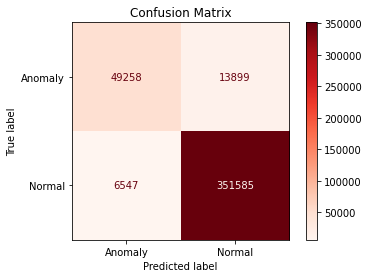

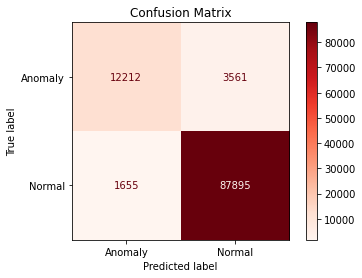

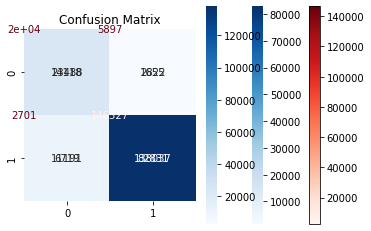

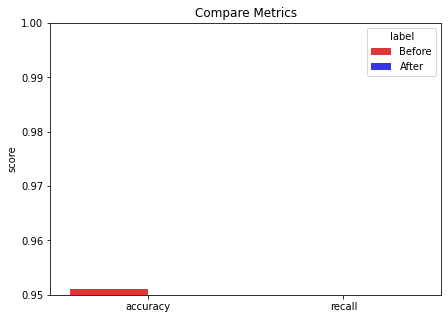

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')


# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)


iidex = 0
llr = 0
mmd = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    if iidex == np.argmax(s_):
      llr = lr
      mmd = md
      print(llr)
      print(mmd)
      break
    iidex += 1

lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=llr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=mmd, skip_drop = threshold)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)


X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)



df_safe['PROB'] = X_pred_prob[:, 0]



with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


# 부산

In [10]:
name_string = 'busan'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob


100000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', 'CSS_AVG_04', '

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"1,139,276.06403","1,680,202.04504",0,0,0,91,"12,924.46464","7,892.79075","2,185.76091","27,723.57680",...,3.26667,1.66935,5.17273,10.40323,13.56452,3.83333,0.70968,2.06667,0.14516,0.10842
1,"1,139,377.59005","1,680,295.81747",1,1,1,10,"12,856.31053","7,881.16110","2,319.53879","27,599.63797",...,3.26667,1.66935,5.17273,10.40323,13.56452,3.83333,0.70968,2.06667,0.14516,0.18534
2,"1,139,321.38914","1,680,252.82014",1,1,1,17,"12,888.40814","7,887.64313","2,252.92714","27,659.90819",...,3.26667,1.66935,5.17273,10.40323,13.56452,3.83333,0.70968,2.06667,0.14516,0.16104
3,"1,139,202.79162","1,681,086.34628",1,1,1,17,"12,403.68103","7,908.67507","1,583.17043","26,927.27887",...,3.26667,1.66935,5.17273,10.40323,13.56452,3.83333,0.70968,2.06667,0.14516,0.07534
4,"1,139,248.47281","1,680,912.63809",1,1,1,17,"12,499.18221","7,901.85823","1,754.61504","27,071.69223",...,3.26667,1.66935,5.17273,10.40323,13.56452,3.83333,0.70968,2.06667,0.14516,0.08151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16359,"1,160,001.59185","1,704,239.73883",2,0,0,82,"24,912.47752","11,766.41441","6,707.98228","52,646.64790",...,2.93333,2.25000,3.85455,10.98387,15.70968,4.80000,1.45161,2.21667,0.09677,0.39041
16360,"1,156,428.39939","1,706,624.98152",2,0,0,82,"24,140.00902","11,827.91360","5,430.02118","51,767.52910",...,2.93333,2.25000,3.85455,10.98387,15.70968,4.80000,1.45161,2.21667,0.09677,0.31027
16361,"1,160,143.48030","1,706,751.47929",2,0,0,82,"26,648.09574","11,889.19069","8,045.53715","54,466.82621",...,2.93333,2.25000,3.85455,10.98387,15.70968,4.80000,1.45161,2.21667,0.09677,0.59695
16362,"1,160,301.85813","1,711,249.68343",2,0,0,82,"30,038.44514","11,944.75877","11,420.92835","57,791.85145",...,2.69167,1.74194,3.70909,6.69355,14.30645,5.00000,1.64516,1.50000,0.12903,0.37968


In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:

    print(lr, md)
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

    a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

    s_ = [i[0] + i[1] for i in a_r]

    lgb_model = lgb_models[np.argmax(s_)]

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')


lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (88688, 273)	X_test.shape: (36954, 273)	X_val.shape: (22173, 273)      
y_train.shape: (88688,)	y_test.shape: (36954,)		y_val.shape: (22173,)
0.01 4
{'fit_time': array([2.39969778, 2.42276669, 2.47566032, 2.49476051, 2.44652057]), 'score_time': array([0.02587914, 0.02828312, 0.02657652, 0.02507567, 0.02575898]), 'test_recall_score': array([0.99936617, 0.99942955, 0.9988591 , 0.99873233, 0.99942951]), 'test_accuracy_score': array([0.89750817, 0.89705717, 0.89891758, 0.89789705, 0.89817895])}
0.01 5
{'fit_time': array([2.62339783, 2.57810044, 2.55725932, 2.55167842, 2.5774343 ]), 'score_time': array([0.02755141, 0.02931666, 0.02675605, 0.02675843, 0.03152847]), 'test_recall_score': array([0.99892248, 0.99898587, 0.9984788 , 0.99797173, 0.99860548]), 'test_accuracy_score': array([0.90094712, 0.90117262, 0.90286391, 0.90116705, 0.9018436 ])}
0.01 6
{'fit_time': array([2.72977948, 2.72381592, 2.77508092, 2.70678997, 2.7773459 ]), 'score_time': array([0.02885628, 0.02945948, 0

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.09000000000000001,
               max_depth=9, objective='binary', random_state=41, subsample=0.75,
               tree_method='gpu_hist')

최적의 accuracy 성능: 0.9342155111760567
최적의 recall 성능: 0.9874326750448833
현재 index: 0
idx: 90	score: 1.9182923160488667
idx: 118	score: 1.9182979672691212
idx: 127	score: 1.9185855203075055
idx: 130	score: 1.9188279734496196
idx: 242	score: 1.9191269387942769
idx: 247	score: 1.9194144918326614
idx: 253	score: 1.9195103428454563
idx: 353	score: 1.919578047622744
idx: 362	score: 1.9196287987392684
idx: 421	score: 1.9197359521925716
idx: 427	score: 1.919837454425621
idx: 447	score: 1.9198431056458753
idx: 486	score: 1.919854408086384
idx: 564	score: 1.9199277640839258
idx: 591	score: 1.9200236150967207
idx: 606	score: 1.9200743662132451
idx: 614	score: 1.92017021722604
idx: 620	score: 1.9201758684462944
idx: 683	score: 1.9202154269880745
idx: 687	score: 1.9203112780008693
idx: 694	score: 1.920362029117394
idx: 701	score: 1.9205086312467132
idx: 722	score: 1.9205142824669676
idx: 737	score: 1.9206101334797623
idx: 756	score: 1.920660884596287
idx: 872	score: 1.9207511942545918
idx: 885	score: 

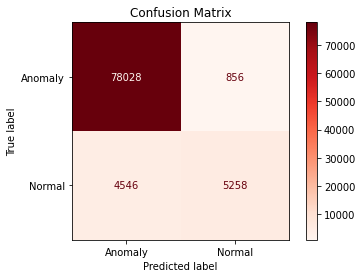

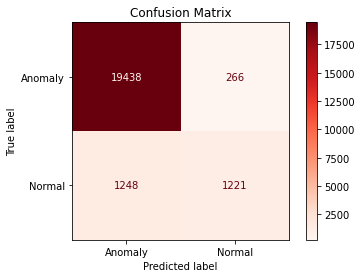

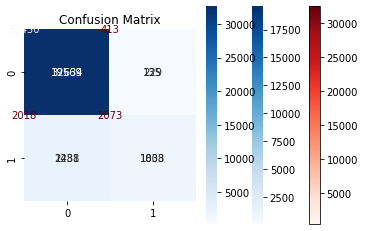

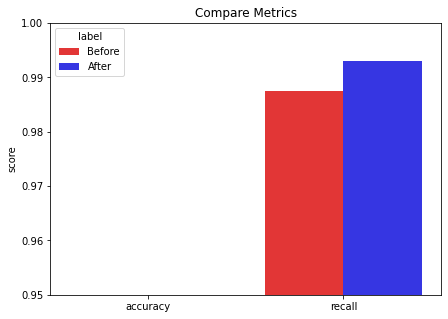

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')


# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)


iidex = 0
llr = 0
mmd = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    if iidex == np.argmax(s_):
      llr = lr
      mmd = md
      print(llr)
      print(mmd)
      break
    iidex += 1

lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=llr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=mmd, skip_drop = threshold)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)


X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)



df_safe['PROB'] = X_pred_prob[:, 0]



with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


# 전북

In [9]:
name_string = 'jeonbuk'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob


100000
100000
200000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', '

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"969,362.02866","1,756,331.61924",0,0,0,91,"38,045.30595","13,380.36765","7,901.88488","73,069.29989",...,2.05000,3.18548,5.97273,8.30645,13.45161,4.03333,1.61290,2.30000,0.14516,0.01895
1,"969,980.70081","1,757,089.23484",0,0,0,91,"38,138.79359","13,473.94378","7,842.18002","74,006.27700",...,2.05000,3.18548,5.97273,8.30645,13.45161,4.03333,1.61290,2.30000,0.14516,0.00727
2,"969,815.99349","1,757,556.94787",0,0,0,91,"38,330.56524","13,529.54996","8,083.00041","74,133.88583",...,2.05000,3.18548,5.97273,8.30645,13.45161,4.03333,1.61290,2.30000,0.14516,0.00531
3,"969,920.84808","1,757,674.20942",0,0,0,91,"38,344.22792","13,549.33516","8,004.01480","74,286.78045",...,2.05000,3.18548,5.97273,8.30645,13.45161,4.03333,1.61290,2.30000,0.14516,0.00531
4,"961,378.08305","1,749,678.56751",0,0,0,91,"38,587.36471","14,707.73600","2,755.65701","77,448.33964",...,2.05000,3.18548,5.97273,8.30645,13.45161,4.03333,1.61290,2.30000,0.14516,0.01172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217542,"913,431.69309","1,744,124.24751",2,0,0,83,"70,653.27300","24,898.51532",364.19816,"124,606.32309",...,1.77500,2.30645,3.35455,6.20968,9.95161,4.41667,1.50000,2.81667,0.25806,0.00128
217543,"931,884.34737","1,745,917.74259",2,0,0,83,"55,530.01328","21,698.68388","3,277.10350","106,445.05456",...,1.77500,2.30645,3.35455,6.20968,9.95161,4.41667,1.50000,2.81667,0.25806,0.09347
217544,"919,252.18774","1,747,015.04578",2,0,0,83,"65,904.89224","23,620.71634","2,280.41896","118,211.10566",...,1.77500,2.30645,3.35455,6.20968,9.95161,4.41667,1.50000,2.81667,0.25806,0.00559
217545,"922,088.65643","1,747,723.08462",2,0,0,83,"63,614.35812","23,066.33185",720.50925,"115,288.09378",...,1.77500,2.30645,3.35455,6.20968,9.95161,4.41667,1.50000,2.81667,0.25806,0.00458


In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:

    print(lr, md)
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

    a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

    s_ = [i[0] + i[1] for i in a_r]

    lgb_model = lgb_models[np.argmax(s_)]

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')


lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (234864, 273)	X_test.shape: (97860, 273)	X_val.shape: (58716, 273)      
y_train.shape: (234864,)	y_test.shape: (97860,)		y_val.shape: (58716,)
0.01 4
{'fit_time': array([7.46913695, 6.89258122, 6.89400673, 6.88228345, 6.99245501]), 'score_time': array([0.0736599 , 0.07199836, 0.07265401, 0.07469916, 0.0785265 ]), 'test_recall_score': array([0.92835592, 0.92758967, 0.93103779, 0.92907428, 0.93031609]), 'test_accuracy_score': array([0.91518532, 0.9152279 , 0.91671811, 0.91518532, 0.91531125])}
0.01 5
{'fit_time': array([7.36723566, 7.26804447, 7.3250134 , 7.27114081, 7.28296971]), 'score_time': array([0.07632947, 0.07683873, 0.07856655, 0.07700706, 0.08530164]), 'test_recall_score': array([0.95086442, 0.94660217, 0.951487  , 0.93022365, 0.94822797]), 'test_accuracy_score': array([0.93347242, 0.93287633, 0.93406851, 0.92538267, 0.93112918])}
0.01 6
{'fit_time': array([7.46008873, 7.4230907 , 7.39595699, 7.8482697 , 7.47224331]), 'score_time': array([0.07666612, 0.08081675,

LGBMClassifier(colsample_bytree=0.8, max_depth=9, objective='binary',
               random_state=41, subsample=0.75, tree_method='gpu_hist')

최적의 accuracy 성능: 0.9622624156958921
최적의 recall 성능: 0.9780553446967083
현재 index: 0
idx: 23	score: 1.941164419499805
idx: 55	score: 1.941168795118362
idx: 64	score: 1.9412242641356516
idx: 66	score: 1.9413352021702313
idx: 93	score: 1.941416453557546
idx: 106	score: 1.9415103604592145
idx: 125	score: 1.9415531739621503
idx: 126	score: 1.9416086429794401
idx: 150	score: 1.9416855187481978
idx: 197	score: 1.9417156767367796
idx: 200	score: 1.9417541146211583
idx: 206	score: 1.9418095836384484
idx: 223	score: 1.941865052655738
idx: 231	score: 1.941920521673028
idx: 261	score: 1.9419463040430527
idx: 269	score: 1.9420017730603425
idx: 321	score: 1.9420533378003921
idx: 416	score: 1.9420752158931767
idx: 419	score: 1.9421306849104665
idx: 450	score: 1.9421350605290235
idx: 466	score: 1.9421734984134023
idx: 476	score: 1.9425447504015199
idx: 568	score: 1.9425627242170642
idx: 576	score: 1.94260553772
idx: 656	score: 1.9426911647258716
idx: 671	score: 1.9427383538473644
idx: 674	score: 1.94284

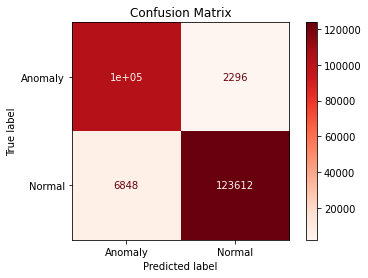

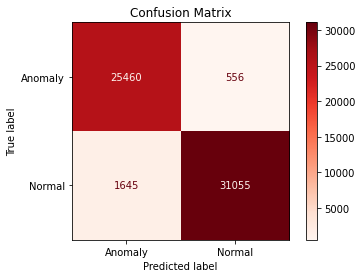

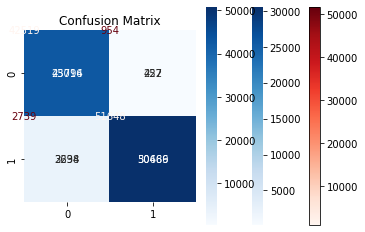

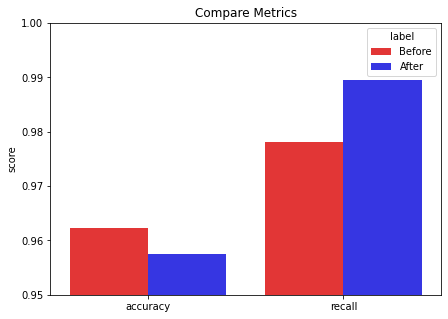

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')


# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)


iidex = 0
llr = 0
mmd = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    if iidex == np.argmax(s_):
      llr = lr
      mmd = md
      print(llr)
      print(mmd)
      break
    iidex += 1

lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=llr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=mmd, skip_drop = threshold)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)


X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)



df_safe['PROB'] = X_pred_prob[:, 0]



with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


# 전남

In [8]:
name_string = 'jeonnam'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

# df_safe.pop('LABEL')
# safe_seed = df_safe.pop('SEED')

# X_pred_prob = df_safe.reset_index(drop=True)

# X_pred_prob = preprocess_type(X_pred_prob)

# X_train, oh_encoder = preprocess_train_nominal(X_train)
# X_test = preprocess_test_nominal(X_test, oh_encoder)
# X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
# X_val = preprocess_test_nominal(X_val, oh_encoder)


# print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
#       \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


# with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
#   lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

# with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
#   lgb_model = pickle.load(f)

# lgb_model.fit(X_train, y_train)




# with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
#   pickle.dump(lgb_model, fw)

# X_pred_prob = df_safe.reset_index(drop=True)

# X_pred_prob = preprocess_type(X_pred_prob)

# X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

# X_pred_prob = lgb_model.predict_proba(X_pred_prob)


# df_safe['PROB'] = X_pred_prob[:, 0]


# with open(str(path / 'dbdata' / name_prob),'wb') as fw:
#   pickle.dump(df_safe, fw)


# with open(str(path / 'dbdata' / name_bug), 'rb') as f:
#   data_bug = pickle.load(f)


# with open(str(path / 'dbdata' / name_prob),'rb') as fw:
#   data_safe_prob = pickle.load(fw)


# data_safe_prob


100000
200000
300000
400000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"891,575.34995","1,644,940.32382",0,0,0,93,"86,694.37866","30,073.53138",0.00000,"162,072.23557",...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
1,"890,951.69482","1,642,284.60278",0,0,0,93,"86,492.52600","30,044.98444",0.00000,"161,839.67176",...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
2,"891,144.49833","1,642,583.62081",0,0,0,93,"67,120.14497","27,594.52350",0.00000,"129,480.53626",...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
3,"891,092.61703","1,642,628.69628",0,0,0,93,"66,582.82622","27,513.46353",0.00000,"128,888.82052",...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
4,"889,989.69992","1,643,352.14481",0,0,0,93,"55,246.83256","28,949.13607",0.00000,"132,098.10378",...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432941,"896,374.07334","1,653,051.66700",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
432942,"896,617.63507","1,653,324.19973",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
432943,"896,186.09854","1,653,400.45914",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009
432944,"897,210.13782","1,653,933.50179",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.11667,1.79839,3.70000,11.93548,6.51613,2.16667,0.53226,2.76667,0.11290,0.00009


In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

idx = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:

    print(lr, md)
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)

    a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

    s_ = [i[0] + i[1] for i in a_r]

    lgb_model = lgb_models[np.argmax(s_)]

a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')


lgb_model = lgb_models[np.argmax(s_)]
lgb_model

X_train.shape: (259857, 273)	X_test.shape: (108275, 273)	X_val.shape: (64965, 273)      
y_train.shape: (259857,)	y_test.shape: (108275,)		y_val.shape: (64965,)
0.01 4
{'fit_time': array([17.99226165, 19.38992143,  6.99770021,  5.68158603,  5.60019636]), 'score_time': array([0.0842824 , 0.08560753, 0.06180334, 0.06059599, 0.06125236]), 'test_recall_score': array([1., 1., 1., 1., 1.]), 'test_accuracy_score': array([1., 1., 1., 1., 1.])}
0.01 5
{'fit_time': array([5.77830005, 5.80729294, 5.83162427, 5.86460829, 5.82675958]), 'score_time': array([0.06284523, 0.06270933, 0.06480241, 0.06409979, 0.06260967]), 'test_recall_score': array([1., 1., 1., 1., 1.]), 'test_accuracy_score': array([1., 1., 1., 1., 1.])}
0.01 6
{'fit_time': array([5.76328039, 5.74418283, 5.74034834, 5.6871438 , 5.80856252]), 'score_time': array([0.06224537, 0.06070566, 0.06257772, 0.06946802, 0.06501651]), 'test_recall_score': array([1., 1., 1., 1., 1.]), 'test_accuracy_score': array([1., 1., 1., 1., 1.])}
0.01 7
{'fit

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=4,
               objective='binary', random_state=41, subsample=0.75,
               tree_method='gpu_hist')

최적의 accuracy 성능: 1.0
최적의 recall 성능: 1.0
현재 index: 0
현재 index: 1000
현재 index: 2000
현재 index: 3000
현재 index: 4000
현재 index: 5000
현재 index: 6000
현재 index: 7000
현재 index: 8000
현재 index: 9000
idx: -1
새로운 threshold: 0.0
새로운 모델 및 임계점에 따른 혼동행렬 결과
0.01
4
0.020000000000000004
4
0.030000000000000006
4
0.04000000000000001
4
0.05000000000000001
4
0.06000000000000001
4
0.07
4
0.08
4
0.09000000000000001
4
0.1
4


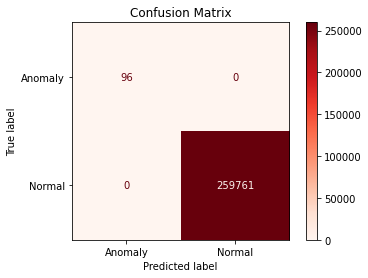

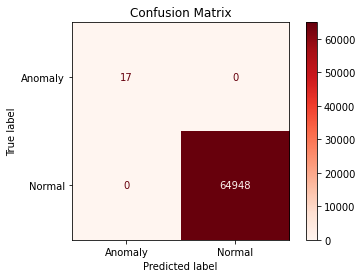

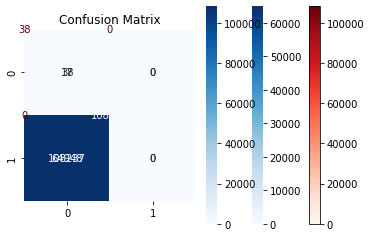

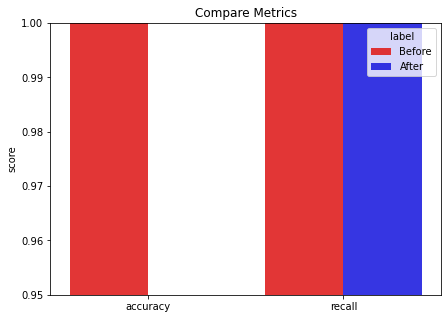

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(0.5, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')

threshold = thr_[idx]
print(f'idx: {idx}')    
print(f'새로운 threshold: {threshold}')

y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')


# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)


iidex = 0
llr = 0
mmd = 0
for lr in lgb_params['learning_rate']:
  for md in max_depth:
    if iidex == np.argmax(s_):
      llr = lr
      mmd = md
      print(llr)
      print(mmd)
      break
    iidex += 1

lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=llr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=mmd, skip_drop = threshold)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)


X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)



df_safe['PROB'] = X_pred_prob[:, 0]



with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


# 충북

In [7]:
name_string = 'chungbuk'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob


100000
200000
300000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', '

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"998,006.36585","1,831,419.46405",0,0,0,91,"56,498.91130","33,117.12581","1,667.45168","121,570.94192",...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00007
1,"1,003,536.16698","1,833,575.14428",0,0,0,91,"52,157.75629","32,568.43212",504.95351,"115,773.90965",...,1.97500,3.08065,3.30000,5.98387,8.61290,6.30000,1.19355,1.71667,0.11290,0.00008
2,"995,960.78171","1,834,858.27279",0,0,0,91,"56,478.72688","32,221.00546","1,109.75934","121,445.95850",...,1.17500,2.08871,2.63636,4.01613,6.69355,5.03333,0.85484,1.26667,0.01613,0.00008
3,"1,001,166.85680","1,833,814.83449",0,0,0,91,"53,469.96023","32,541.81776","2,036.49347","117,612.14639",...,1.17500,2.08871,2.63636,4.01613,6.69355,5.03333,0.85484,1.26667,0.01613,0.00012
4,"999,014.73695","1,834,869.43459",0,0,0,91,"54,427.92855","32,248.79568","2,856.04790","118,848.36355",...,1.17500,2.08871,2.63636,4.01613,6.69355,5.03333,0.85484,1.26667,0.01613,0.00011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335428,"1,074,854.18057","1,906,495.18048",2,0,0,82,"63,808.98333","35,557.87223","2,445.04947","133,950.38927",...,1.51724,4.38710,4.49091,11.06452,10.88710,7.25000,2.51613,2.03333,0.09677,0.00046
335429,"1,078,430.05361","1,906,560.89351",2,0,0,82,"65,992.53138","35,910.29072",920.01442,"135,562.55946",...,1.51724,4.38710,4.49091,11.06452,10.88710,7.25000,2.51613,2.03333,0.09677,0.00006
335430,"1,074,429.27684","1,906,924.79807",2,0,0,82,"63,811.98541","35,584.36673","2,451.24900","134,160.95680",...,1.51724,4.38710,4.49091,11.06452,10.88710,7.25000,2.51613,2.03333,0.09677,0.00072
335431,"1,077,085.82450","1,906,541.09692",1,2,1,11,"65,152.40654","35,792.83939",714.79549,"134,952.06930",...,1.51724,4.38710,4.49091,11.06452,10.88710,7.25000,2.51613,2.03333,0.09677,0.00050


# 충남

In [11]:
name_string = 'chungnam'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob


100000
200000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', 'CSS_AVG

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"958,741.05696","1,852,399.37130",0,0,0,91,"44,131.78080","21,600.14460","1,250.86180","85,305.18603",...,1.74167,2.26613,2.53636,4.54839,8.75806,9.31667,1.20968,2.31667,0.22581,0.00026
1,"959,569.47585","1,851,040.60423",0,0,0,93,"43,912.42966","21,482.21902","1,404.50203","83,721.80617",...,1.74167,2.26613,2.53636,4.54839,8.75806,9.31667,1.20968,2.31667,0.22581,0.00017
2,"959,723.35582","1,851,874.47992",0,0,0,93,"44,340.30992","21,539.78454","1,665.07686","84,293.45977",...,1.74167,2.26613,2.53636,4.54839,8.75806,9.31667,1.20968,2.31667,0.22581,0.00023
3,"959,726.17585","1,852,007.09327",0,0,0,93,"44,399.79461","21,548.89274","1,756.27046","84,397.80571",...,1.74167,2.26613,2.53636,4.54839,8.75806,9.31667,1.20968,2.31667,0.22581,0.00023
4,"960,735.16284","1,852,138.12288",0,0,0,93,"44,930.98671","21,529.86281","1,414.23994","83,901.15382",...,1.74167,2.26613,2.53636,4.54839,8.75806,9.31667,1.20968,2.31667,0.22581,0.00013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281227,"897,157.37624","1,866,419.47303",2,0,0,82,"60,992.85754","31,002.99227","2,960.60196","139,779.74913",...,2.37500,2.41129,3.39091,3.20968,7.17742,8.16667,1.22581,3.28333,0.30645,0.00002
281228,"897,282.05164","1,866,443.40519",2,0,0,82,"60,924.13914","30,993.84164","2,866.75473","139,692.75179",...,2.37500,2.41129,3.39091,3.20968,7.17742,8.16667,1.22581,3.28333,0.30645,0.00002
281229,"896,489.29971","1,867,097.83374",2,0,0,82,"61,749.65803","31,215.40585","2,622.74270","140,718.95503",...,2.37500,2.41129,3.39091,3.20968,7.17742,8.16667,1.22581,3.28333,0.30645,0.00001
281230,"897,257.41479","1,866,964.05615",2,0,0,82,"61,190.14688","31,103.71659","2,481.00029","140,018.75444",...,2.37500,2.41129,3.39091,3.20968,7.17742,8.16667,1.22581,3.28333,0.30645,0.00002


# 대전

In [ ]:
name_string = 'daejeon'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob

['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', 'CSS_AVG_04', 'MIN_CSS

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"995,292.97807","1,810,068.64366",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
1,"997,581.85554","1,811,388.17239",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
2,"998,101.45192","1,809,654.17920",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
3,"998,156.32240","1,809,921.09939",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
4,"993,900.14062","1,810,079.80481",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19981,"995,167.67235","1,826,899.43929",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
19982,"994,615.51477","1,827,008.51774",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
19983,"994,524.58435","1,827,052.70934",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000
19984,"992,203.76592","1,825,771.39685",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,2.25000,2.76613,2.76364,4.56452,9.91935,5.00000,1.70968,1.58333,0.12903,0.00000


# 대구

In [ ]:
name_string = 'daegu'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob

100000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', 'CSS_AVG_04', '

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"1,097,247.95075","1,764,695.93753",1,2,2,30,"16,425.44066","4,684.49198","10,532.09917","27,744.33642",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.00921
1,"1,102,676.85356","1,777,985.34268",0,0,0,91,"25,988.13225","9,914.32447","2,418.04398","41,763.42794",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.02974
2,"1,105,326.08585","1,775,059.00338",0,0,0,91,"24,422.88480","10,056.76320","1,364.71405","40,887.39363",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.04815
3,"1,110,827.55875","1,775,337.11060",0,0,0,91,"27,177.92582","10,732.10812","4,169.00590","44,669.75161",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.06029
4,"1,102,316.63092","1,775,805.00351",0,0,0,91,"24,147.38189","9,530.47873","1,784.55944","39,737.87441",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.09838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26552,"1,091,380.63227","1,766,034.35553",2,0,0,82,"16,929.12553","6,240.11374","4,577.22925","25,809.14381",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.78792
26553,"1,091,150.92414","1,764,367.51829",2,0,0,82,"16,118.53908","5,859.34977","4,657.35894","24,209.53214",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.55499
26554,"1,090,897.35799","1,765,196.24201",2,0,0,82,"16,534.85481","6,200.39378","4,179.41253","24,844.61724",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.73146
26555,"1,090,929.17651","1,765,437.82813",2,0,0,82,"16,652.66782","6,255.36971","4,169.02381","25,076.93896",...,1.46491,1.38333,2.90000,6.67742,7.46774,3.18333,1.90323,1.35000,0.00000,0.75442


# 광주

In [ ]:
name_string = 'gwangju'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_03', 'PDOS_HR_03', 'CSS_GRD_AVG_03', 'MIN_CSS_GRD_03', 'CSS_AVG_04', 'MIN_CSS

In [ ]:
data_safe_prob

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"948,278.47446","1,676,639.84245",0,0,0,93,"20,959.11847","7,603.36830","2,663.99841","25,440.95525",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00106
1,"950,355.21759","1,675,836.58629",1,1,1,14,"22,962.61087","7,824.31858","4,804.86987","27,635.08034",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00092
2,"950,416.86424","1,676,299.87905",1,1,1,14,"22,812.11440","7,841.57493","4,816.65945","27,455.08675",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00109
3,"950,489.51464","1,676,018.26654",1,1,1,14,"22,991.66508","7,843.26137","4,917.98289","27,658.84264",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00086
4,"950,013.10188","1,675,754.42390",1,1,1,14,"22,724.30235","7,786.27954","4,477.56526","27,383.73321",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13427,"940,539.98947","1,689,777.92191",2,0,0,81,"14,495.53526","3,445.56618","9,433.32581","19,348.90362",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00673
13428,"940,718.11193","1,690,175.52767",2,0,0,82,"14,690.94437","3,596.10153","9,382.38472","19,697.40884",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.04029
13429,"938,976.61707","1,689,914.40916",2,0,0,82,"13,628.61530","3,164.55477","8,474.06341","18,061.67431",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00314
13430,"940,771.50479","1,689,311.67321",2,0,0,82,"14,536.69065","3,410.71298","9,089.55586","19,336.18884",...,1.49167,1.91129,2.63889,7.01613,9.16129,3.85000,0.45000,2.73333,0.35484,0.00772


# 

# 제주

In [ ]:
name_string = 'jeju'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob

100000
200000
300000
400000
500000
600000
100000
200000
300000
400000
500000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS_GRD_02', 'CSS_AVG_03', 'MIN_CSS_AVG_03', 'MAX_CSS_AVG_03', 'MAX_IWS_DEG_03', 'MAX_WS_MS_03', 'MAX_WS_DEG_03', 'WS_AVG_MS_03', 'MAX_WO_DEG_03', 'CSS_DEW_AVG_03', 'MIN_REL_HUMID_03', 'REL_HUMID_AVG_03', 'VAPOR_AVG_03', 'VAPOR_LOCAL_AVG_

In [ ]:
data_safe_prob

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"931,986.09760","1,493,221.13690",1,2,1,15,"21,670.41102","14,936.27668","3,789.67645","74,640.43225",...,3.95000,3.58871,7.09091,7.09677,13.74194,15.51667,2.58065,2.95000,0.87097,0.51898
1,"931,979.05690","1,493,212.17380",1,2,1,15,"21,665.19075","14,933.27393","3,796.46567","74,643.48543",...,3.95000,3.58871,7.09091,7.09677,13.74194,15.51667,2.58065,2.95000,0.87097,0.51898
2,"931,979.04730","1,493,210.17450",1,2,1,15,"21,665.00050","14,933.00554","3,798.39288","74,645.09133",...,3.95000,3.58871,7.09091,7.09677,13.74194,15.51667,2.58065,2.95000,0.87097,0.51898
3,"931,976.05310","1,493,211.18850",1,2,1,15,"21,663.22614","14,932.37077","3,796.62837","74,642.50026",...,3.95000,3.58871,7.09091,7.09677,13.74194,15.51667,2.58065,2.95000,0.87097,0.51898
4,"931,973.05420","1,493,211.20300",1,2,1,15,"21,661.35703","14,931.60177","3,795.82955","74,640.71216",...,3.95000,3.58871,7.09091,7.09677,13.74194,15.51667,2.58065,2.95000,0.87097,0.51898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591972,"897,300.17950","1,490,740.68870",1,2,3,77,"23,292.24079","11,663.79317","2,830.01208","63,337.74748",...,2.65833,2.02419,5.59091,7.96774,12.66667,19.95000,1.91935,3.46667,1.03226,0.50247
591973,"897,299.12220","1,490,728.69730",1,2,3,77,"23,289.72940","11,668.83254","2,828.48783","63,349.44717",...,2.65833,2.02419,5.59091,7.96774,12.66667,19.95000,1.91935,3.46667,1.03226,0.50247
591974,"897,344.99690","1,490,705.48370",1,2,3,77,"23,255.38561","11,666.26172","2,778.76278","63,379.30920",...,2.65833,2.02419,5.59091,7.96774,12.66667,19.95000,1.91935,3.46667,1.03226,0.50247
591975,"897,384.85920","1,490,679.29990",2,0,0,81,"23,224.01732","11,666.41835","2,734.39455","63,411.22483",...,2.65833,2.02419,5.59091,7.96774,12.66667,19.95000,1.91935,3.46667,1.03226,0.49854


# 경북

In [ ]:
name_string = 'gyeongbuk'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


df_bug = bug_step(data_bug)
df_safe = safe_step(data_safe)

df_total, df_safe, y = encode_ml(df_bug, df_safe)

X_train, y_train, X_test, y_test, X_val, y_val = split_data(df_total, y)

seeds = []

s1 = X_train.pop('SEED')
s2 = X_test.pop('SEED')
s3 = X_val.pop('SEED')

seeds.extend(s1)
seeds.extend(s2)
seeds.extend(s3)


X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

df_safe.pop('LABEL')
safe_seed = df_safe.pop('SEED')

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)


print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

# 전체 데이터로 파라미터 그리드 서치
# lgb_score_ = []

# lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
# max_depth = [md for md in range(4, 10)]

# scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
#           'accuracy_score': make_scorer(accuracy_score)}

# lgb_models = []

# idx = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:

#     print(lr, md)
    
#     lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
#                                 colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
#                                 max_depth=md)

#     lgb_models.append(lgb_model)

#     lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
#     lgb_score_.append(lgb_score)
#     print(lgb_score)

#     a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

#     s_ = [i[0] + i[1] for i in a_r]

#     lgb_model = lgb_models[np.argmax(s_)]

# a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

# s_ = [i[0] + i[1] for i in a_r]

# print(f'Max Score Index: {np.argmax(s_)}')
# print(f'Max Score: {s_[np.argmax(s_)]}')


# lgb_model = lgb_models[np.argmax(s_)]


with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)


# print(lgb_model)

# lgb_model.fit(X_train, y_train)

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_train, y_train,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_test_pred = lgb_model.predict(X_test)

# acc_1 = accuracy_score(y_test, y_test_pred)
# recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
# print(f'최적의 accuracy 성능: {acc_1}')
# print(f'최적의 recall 성능: {recall_1}')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_val, y_val,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# label=['Anomaly', 'Normal']

# plot = plot_confusion_matrix(lgb_model,
#                              X_test, y_test,
#                              display_labels=label,
#                              cmap=plt.cm.Reds,
#                              normalize=None)

# plot.ax_.set_title('Confusion Matrix')

# y_val_prob = lgb_model.predict_proba(X_val)
# y_val_pred = lgb_model.predict(X_val)
# score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

# thr_ = np.linspace(0.5, 0, 10000)
# idx = -1
# for i, thr in enumerate(thr_):
#   y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
#   tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

#   if score < tmp_score:
#     score = tmp_score
#     idx = i
#     print(f'idx: {idx}\tscore: {score}')

#   if i % 1000 == 0:
#     print(f'현재 index: {i}')

# threshold = thr_[idx]
# print(f'idx: {idx}')    
# print(f'새로운 threshold: {threshold}')

# y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

# sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')
# plot.ax_.set_title('Confusion Matrix')

# y_test_prob = lgb_model.predict_proba(X_test)

# y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

# print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

# acc_2 = accuracy_score(y_test, y_test_pred)
# recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


# plt.title('Confusion Matrix')
# sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
#                              cmap=plt.cm.Blues, fmt='g')


# # 후처리 성능 비교
# colors = ["red", "blue"]
# sns.set_palette(sns.color_palette(colors))

# postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
#                          'label':['Before', 'After', 'Before', 'After'],
#                          'score':[acc_1, acc_2, recall_1, recall_2]})

# plt.figure(figsize=(7, 5))
# plt.title('Compare Metrics')
# ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
# plt.xlabel('')
# plt.ylim(0.95, 1)


# iidex = 0
# llr = 0
# mmd = 0
# for lr in lgb_params['learning_rate']:
#   for md in max_depth:
#     if iidex == np.argmax(s_):
#       llr = lr
#       mmd = md
#       print(llr)
#       print(mmd)
#       break
#     iidex += 1

with open(str(path / 'save_model' / name_safe_mode),'rb') as f:
  lgb_model = pickle.load(f)

lgb_model.fit(X_train, y_train)




with open(str(path / 'save_model' / name_safe_mode),'wb') as fw:
  pickle.dump(lgb_model, fw)

X_pred_prob = df_safe.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)


df_safe['PROB'] = X_pred_prob[:, 0]


with open(str(path / 'dbdata' / name_prob),'wb') as fw:
  pickle.dump(df_safe, fw)


with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)


with open(str(path / 'dbdata' / name_prob),'rb') as fw:
  data_safe_prob = pickle.load(fw)


data_safe_prob

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
100000
200000
300000
400000
500000
600000
700000
['LATITUDE', 'LONGITUDE', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'SEED', 'DROP', 'DROP', 'DROP', 'CSS_AVG_01', 'MIN_CSS_AVG_01', 'MAX_CSS_AVG_01', 'MAX_IWS_DEG_01', 'MAX_WS_MS_01', 'MAX_WS_DEG_01', 'WS_AVG_MS_01', 'MAX_WO_DEG_01', 'CSS_DEW_AVG_01', 'MIN_REL_HUMID_01', 'REL_HUMID_AVG_01', 'VAPOR_AVG_01', 'VAPOR_LOCAL_AVG_01', 'PDOS_HR_01', 'CSS_GRD_AVG_01', 'MIN_CSS_GRD_01', 'CSS_AVG_02', 'MIN_CSS_AVG_02', 'MAX_CSS_AVG_02', 'MAX_IWS_DEG_02', 'MAX_WS_MS_02', 'MAX_WS_DEG_02', 'WS_AVG_MS_02', 'MAX_WO_DEG_02', 'CSS_DEW_AVG_02', 'MIN_REL_HUMID_02', 'REL_HUMID_AVG_02', 'VAPOR_AVG_02', 'VAPOR_LOCAL_AVG_02', 'PDOS_HR_02', 'CSS_GRD_AVG_02', 'MIN_CSS

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"1,180,016.50222","1,765,769.33908",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,0.00003
1,"1,174,724.26493","1,769,753.05216",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,0.00003
2,"1,181,302.55577","1,772,994.13469",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,0.00003
3,"1,166,816.22327","1,775,662.92559",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,0.00003
4,"1,184,969.80288","1,781,248.71002",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,0.00003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796771,"1,301,248.91859","1,954,537.02911",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,0.00003
796772,"1,296,437.20616","1,946,138.66932",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,0.00003
796773,"1,294,550.43042","1,946,476.91504",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,0.00003
796774,"1,291,750.98383","1,951,638.73890",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,0.00003


In [ ]:
df_safe

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"1,180,016.50222","1,765,769.33908",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,180,016.50222"
1,"1,174,724.26493","1,769,753.05216",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,174,724.26493"
2,"1,181,302.55577","1,772,994.13469",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,181,302.55577"
3,"1,166,816.22327","1,775,662.92559",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,166,816.22327"
4,"1,184,969.80288","1,781,248.71002",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,184,969.80288"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796771,"1,301,248.91859","1,954,537.02911",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,301,248.91859"
796772,"1,296,437.20616","1,946,138.66932",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,296,437.20616"
796773,"1,294,550.43042","1,946,476.91504",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,294,550.43042"
796774,"1,291,750.98383","1,951,638.73890",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,291,750.98383"


In [ ]:
data_safe_prob

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,PROB
0,"1,180,016.50222","1,765,769.33908",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,180,016.50222"
1,"1,174,724.26493","1,769,753.05216",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,174,724.26493"
2,"1,181,302.55577","1,772,994.13469",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,181,302.55577"
3,"1,166,816.22327","1,775,662.92559",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,166,816.22327"
4,"1,184,969.80288","1,781,248.71002",0,0,0,91,-1.00000,-1.00000,-1.00000,-1.00000,...,1.79167,1.93548,2.59375,7.83333,12.01613,4.63333,1.88710,1.35000,0.00000,"1,184,969.80288"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796771,"1,301,248.91859","1,954,537.02911",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,301,248.91859"
796772,"1,296,437.20616","1,946,138.66932",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,296,437.20616"
796773,"1,294,550.43042","1,946,476.91504",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,294,550.43042"
796774,"1,291,750.98383","1,951,638.73890",2,0,0,82,-1.00000,-1.00000,-1.00000,-1.00000,...,3.88333,1.97581,3.82407,3.20968,13.30645,5.28333,5.96774,1.40000,3.88710,"1,291,750.98383"
